In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Import packages
import os 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from ipywidgets import fixed, Dropdown, HBox, interactive_output

# Import custom functions
from load_data import load_data, load_all
from plotting import plot_simulations, select_sim, scale_time

In [12]:
#define quantity to plot
y = "Partial Pressure CO2"

In [13]:
curdir = os.path.curdir
data_dir = "data"
model_dir = "nabity"
fault_dir = "Nominal"
sim = "CDRA_nominal.parquet"

fault_path = os.path.join(curdir, data_dir, model_dir, fault_dir)
sim_path = os.path.join(fault_path, sim)

In [14]:
# read data and load into dataframes
y = ["Partial Pressure CO2"]

# create datafram for nominal data
data = load_data(y, sim_path)
df_nominal = scale_time(data, time_unit="h")

# create dataframe for anomaly data
df_all = load_all(y, fault_path)

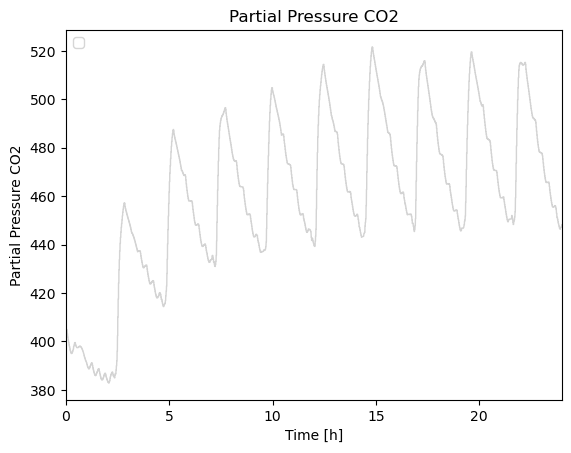

In [15]:
simulations = df_all["Simulation"].unique().tolist()

# Plot all simulations in gray initially
fig, ax = plot_simulations(df_all, quantity, [0, 24])
simulations = df_all["Simulation"].unique().tolist()

select_sim("CDRA_heater_fault_off", ax)

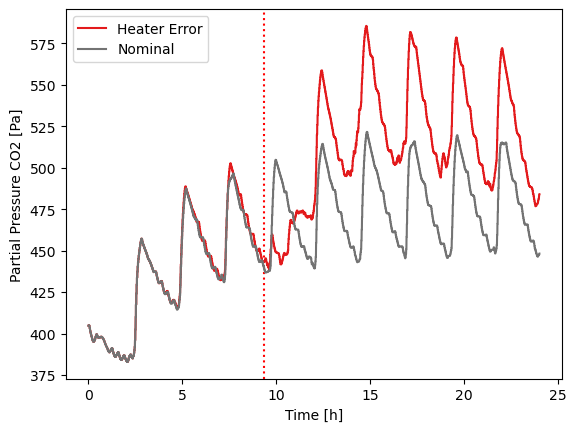

In [6]:
simulations = df_all["Simulation"].unique().tolist()
df_heater = df_all[df_all["Simulation"] == simulations[0]]

t_anomaly = 144*(2.9+1)*60 / 3600
plt.axvline(x=t_anomaly, linestyle=":", color="red")

plt.plot(df_heater["Time"], df_heater[quantity], color='#e31a1c', label='Heater Error')
plt.plot(df_nominal["Time"], df_nominal[quantity], color='#737373', linestyle='-', label='Nominal')
plt.xlabel("Time [h]")
plt.ylabel("Partial Pressure CO2 [Pa]")
plt.legend()



In [210]:
df_heater_off = df_all[df_all["Simulation"]=="CDRA_heater_fault_off"]
df_heater_off = df_heater_off.drop(["Simulation", "OriginalTime"], axis=1)
df_heater_off

,Time,Partial Pressure CO2
0,0.000000e+00,404.695831
1,2.777778e-12,404.695831
2,5.555556e-12,404.695831
3,8.333333e-12,404.695831
4,1.111111e-11,404.695831
...,...,...
5553,2.395982e+01,481.397456
5554,2.396815e+01,481.397456
5555,2.397649e+01,481.397456
5556,2.399315e+01,484.082718


In [211]:
from scipy.interpolate import interp1d


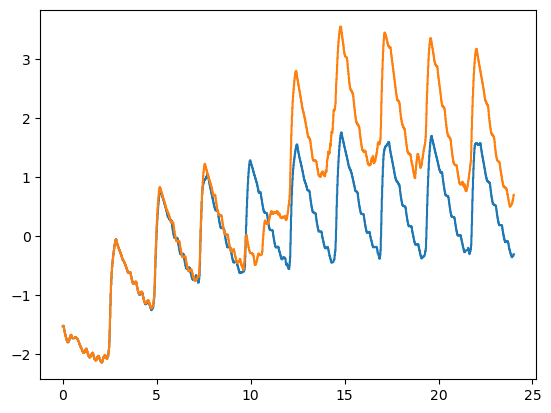

In [212]:
# Training data

readings_train = df_nominal["Partial Pressure CO2"].tolist()
t_train = df_nominal["Time"].tolist()
t_unit = 'hour'

#np.save("../vae-lstm/datasets/CDRA/train_dataset", readings_train)

# Later: interpolate data for uniform mesh
#t_uniform = np.linspace(min(t), max(t), num=3*len(t))
#interpolated_data = interp1d(t, readings_train, kind='linear')(t_uniform)


idx_anomaly = (df_heater_off["Time"] - t_anomaly).abs().argmin()
train_m = np.mean(readings_train)
train_std = np.std(readings_train)
training = (readings_train - train_m)/train_std #z-score

plt.plot(t_train, training)

# Test data
df = df_heater_off
readings_test = df["Partial Pressure CO2"].tolist()
t_test = df["Time"].tolist()
t_unit = 'hour'

#np.save("../vae-lstm/datasets/CDRA/test_dataset", readings_test)

idx_anomaly = (df_heater_off["Time"] - t_anomaly).abs().argmin()
test = (readings_test - train_m)/train_std #z-score

plt.plot(t_test, test)

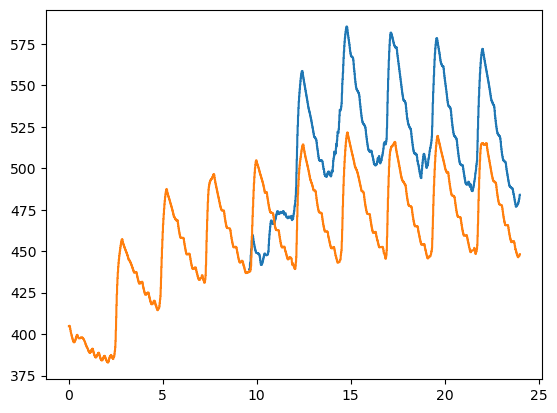

In [213]:
readings_train[-1]
anomaly_time = 144*(4)*60 / 3600
idx_anomaly = np.argmin(np.abs(np.array(t_test) - anomaly_time)) 
cutted_readings_test = readings_test[idx_anomaly:]
cutted_t_test = t_test[idx_anomaly:]

plt.plot(cutted_t_test, cutted_readings_test)
plt.plot(t_train, readings_train)

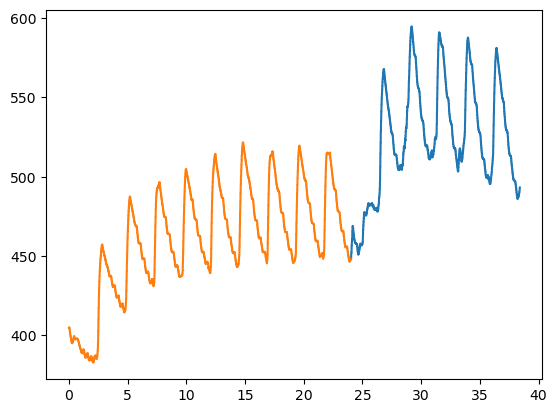

In [214]:
delta = readings_train[-1] - cutted_readings_test[0]
# move test data vertically to be aligned with last entry of train data
lifted_readings_test = [ppCO2 + delta for ppCO2 in cutted_readings_test]
# add offset to time to account for future
t_shifted = [t + t_train[-1] - anomaly_time for t in cutted_t_test]

plt.plot(t_shifted, lifted_readings_test)
plt.plot(t_train, readings_train)

In [215]:
# append both time array for train and shifted time to one
t_final = t_train + t_shifted
# append both data sets
data = readings_train + lifted_readings_test

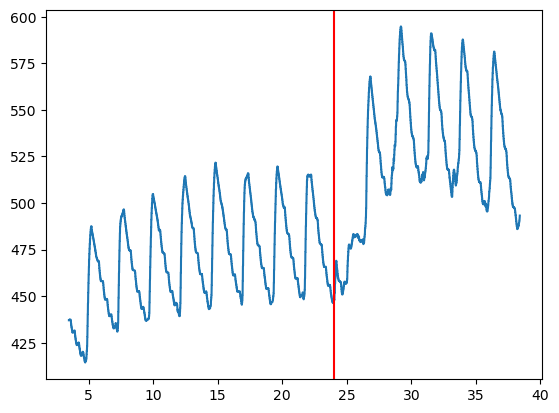

In [216]:
t = t_final[1000:]
data = data[1000:]
plt.plot(t, data)
plt.axvline(t_shifted[0], color='red')

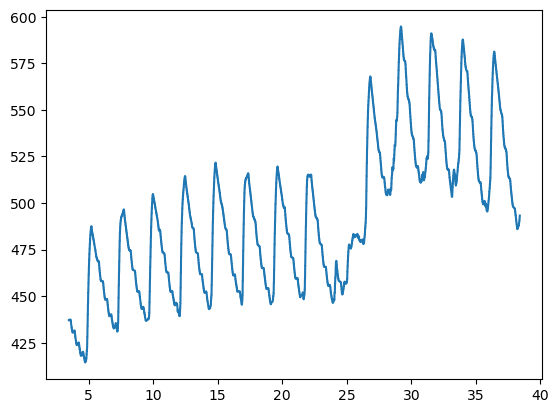

In [217]:
from scipy.interpolate import interp1d

x_uniform = np.linspace(min(t), max(t), 10000)

# Interpolate y values on the uniform grid
f = interp1d(t, data, kind='linear') 
y_uniform = f(x_uniform)

plt.plot(x_uniform, y_uniform)
x_delta = [i - j for (i,j) in zip(x_uniform[1:], x_uniform)]

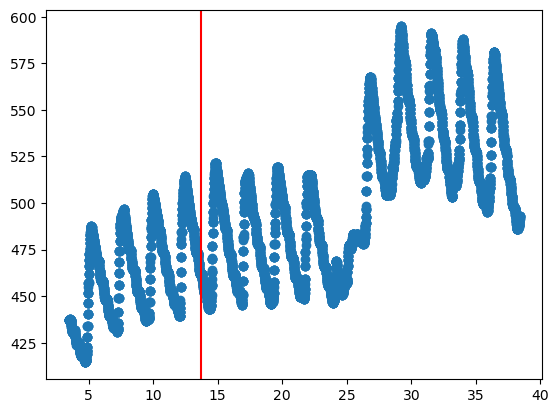

In [218]:
t = x_uniform
data = y_uniform

df = pd.DataFrame(data={"Time": t, "Partial Pressure CO2": data})
plt.scatter(df["Time"], df["Partial Pressure CO2"])
plt.axvline(t[2940], color='red')
df.to_parquet("../VAE-LSTM-for-anomaly-detection-master/datasets/CDRA/heater_off_err.parquet")

In [219]:
idx_anomaly = np.argmin(np.abs(np.array(t) - t_shifted[0])) 
idx_anomaly

np.int64(5878)

In [220]:
x = [1,2,3,4]
x[-1]

4

Next Steps:

- original algorithm uses one timeseries for train and test --> make it work with two distinct series
  This might require changes as the time series starts from 0 again --> just try it yolo

- run algorithm

- interpolate

- data: not steady state = annoying asf --> solve matlab or validate fault data until error. If it runs long enough wayne, just take it